# Using the LSST Stack tools to do positional matching on coadd and src catalogs
<br>Owner: **Jim Chiang** ([@jchiang87](https://github.com/LSSTDESC/DC2_Repo/issues/new?body=@jchiang87))
<br>Last Run: **2018-07-15**

In this notebook, we use the data butler to retrieve catalogs from coadd and visit-level analyses of Run1.1p, and use the `lsst.afw.table.matchRaDec` function to do positional matching against galaxy truth info extracted from the proto-dc2 v2.1.2 extragalactic catalog.  To enable this, we show how to create a `SourceCatalog` object from the galaxy truth info provided by the GCR interface.

## Set Up

In [1]:
import warnings
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import lsst.afw.geom as afw_geom
import lsst.afw.table as afw_table
import lsst.daf.persistence as dp
import GCRCatalogs

Normally, the following code to rotate the protoDC2 field to the Run1.1p field would be imported from the `LSSTDESC/sims_GCRCatSimInterface` package, but we include it here so that the `desc-stack` kernel can be used without modifying it to include the various DESC packages used with Run1.1p.

In [2]:
from Matching.fieldRotator import FieldRotator

## How To Create a Source Catalog

In order to use the Stack's spatial matching code, we will need to reformat the extragalactic catalog galaxy position and magnitude information into an afw `SourceCatalog` object. These table objects are initialized by a "schema", which in turn is built from column definition "Coldef" objects.  The `mag_cols` function below shows how these Coldefs can be created.

In [3]:
def make_SourceCatalog(new_cols):
    """
    Make a SourceCatalog to contain id and coordinates for each object, plus any new
    columns.
    
    Parameters
    ----------
    new_cols: list of Coldefs
        Column info for adding to an afw.table schema.

    Returns
    -------
    lsst.afw.table.SourceCatalog: An empty SourceCatalog with the desired schema.
    """
    # The minimal schema just contains the `id`, `coord_ra`, and `coord_dec` fields.
    schema = afw_table.SourceTable.makeMinimalSchema()
    for coldef in new_cols:
        schema.addField(coldef.name, type=coldef.type, doc=coldef.doc)
    return afw_table.SourceCatalog(schema)


def mag_cols(bands):
    """Return column information for adding magnitude columns to an afw.table schema."""
    Coldef = namedtuple('Coldef', 'name type doc'.split())
    return [Coldef('mag_{}'.format(x), float, '{}-magnitude'.format(x))
            for x in bands]

## Selecting Galaxies

We will need a helper class to rotate the protoDC2 galaxies to the Run1.1p locations, and then downselect for the sky region being considered. We'll make a general-purpose RegionSelector class, and then sub-class it for selecting objects in either CCDs or patches.

In [4]:
class RegionSelector:
    """
    Class to rotate the protoDC2 galaxies to the Run1.1p sky location and downselect those galaxies
    based on a magnitude limit and on the coordinates of the subregion (i.e., patch or CCD) being
    considered.
    """
    protoDC2_ra = 55.064
    protoDC2_dec = -29.783
    field_rotator = FieldRotator(0, 0, protoDC2_ra, protoDC2_dec)

    def __init__(self):
        pass
    
    def _set_coord_range(self, bbox, wcs):
        """
        Set the coordinate range of the region.
        
        Notes
        -----
        This method is used by the RegionSelector's subclasses.
        
        Parameters
        ----------
        bbox: Calexp.BBox
            Defines corners of region's bounding box
        wcs: Calexp.Wcs
            Defines pixel to world (sky) coordinate transformation
        """
        region_box = afw_geom.Box2D(bbox)
        corners = region_box.getCorners()
        ra_values, dec_values = [], []
        for corner in corners:
            ra, dec = wcs.pixelToSky(corner)
            ra_values.append(ra.asDegrees())
            dec_values.append(dec.asDegrees())
        self.ra_range = min(ra_values), max(ra_values)
        self.dec_range = min(dec_values), max(dec_values)

    def __call__(self, gc, band, max_mag):
        """
        Create a SourceCatalog object from the input galaxy catalog for the specified band, and
        apply the region and magnitude cuts.

        Parameters
        ----------
        gc: GCRCatalogs GalaxyCatalog
            The galaxy catalog obtained via GCR.
        band: str
            The band, e.g., 'i', to use for the magnitude comparison with the values measured
            from the simulated data.
        max_mag: float
            The magnitude limit to apply.

        Returns
        -------
        lsst.afw.table.SourceCatalog
        """
        # Retrieve the desired columns and cut on the magnitude values.
        bandname = 'mag_true_{}_lsst'.format(band)
        filter_ = '{} < {}'.format(bandname, max_mag)
        print("Applying magnitude filter:", filter_)
        gc_cols = gc.get_quantities(['galaxy_id', 'ra_true', 'dec_true',
                                     bandname], filters=[filter_])
        print("Number of galaxies passing magnitude filter:", len(gc_cols[bandname]))

        # Rotate to the Run1.1p field.
        gc_ra_rot, gc_dec_rot \
            = self.field_rotator.transform(gc_cols['ra_true'],
                                           gc_cols['dec_true'])

        # Select the galaxies within the region.
        index = np.where((gc_ra_rot > self.ra_range[0]) &
                         (gc_ra_rot < self.ra_range[1]) &
                         (gc_dec_rot > self.dec_range[0]) &
                         (gc_dec_rot < self.dec_range[1]))
        galaxy_id = gc_cols['galaxy_id'][index]
        gc_ra = gc_ra_rot[index]
        gc_dec = gc_dec_rot[index]
        gc_mag = gc_cols[bandname][index]
        print("Number of galaxies within region:", len(galaxy_id))

        # Create a SourceCatalog with the galaxy_ids, coordinates, magnitudes
        galaxy_catalog = make_SourceCatalog(mag_cols((band,)))
        for id_, ra, dec, mag in zip(galaxy_id, gc_ra, gc_dec, gc_mag):
            record = galaxy_catalog.addNew()
            record.set('id', id_)
            record.set('coord_ra', afw_geom.Angle(ra, afw_geom.degrees))
            record.set('coord_dec', afw_geom.Angle(dec, afw_geom.degrees))
            record.set('mag_{}'.format(band), mag)
        return galaxy_catalog

In [5]:
class CcdSelector(RegionSelector):
    """RegionSelector to use with visit-level calexps, i.e., single CCD exposures."""
    def __init__(self, butler, visit, raft, sensor):
        super(CcdSelector, self).__init__()
        # Get the CCD boundaries
        dataId = dict(visit=visit, raft=raft, sensor=sensor)
        calexp = butler.get('calexp', dataId=dataId)
        self._set_coord_range(calexp.getBBox(), calexp.getWcs())


class PatchSelector(RegionSelector):
    """RegionSelector to use with skyMap patches, i.e., coadd data."""
    def __init__(self, butler, tract, patch):
        super(PatchSelector, self).__init__()
        # Get the patch boundaries.
        skymap = butler.get('deepCoadd_skyMap')
        tractInfo = skymap[tract]
        patchInfo = tractInfo.getPatchInfo(eval(patch))
        self._set_coord_range(patchInfo.getOuterBBox(), tractInfo.getWcs())

## Matching Experiments

Now we have the tools we need, let's read in the Run 1.1p DRP catalog data and match it to the extragalactic catalog input. 

In [6]:
# Create a data butler for the repo.
repo = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/output'
butler = dp.Butler(repo)

### Sources or Objects?

We can consider visit-level src catalog data, in which case we would provide a `dataId` to the butler with (`visit`, `raft`, `sensor`) ids; or we can consider coadd object data, for which we would provid a `dataId` with (`filter`, `tract`, `patch`) ids.

Somewhat different flux models are available in the Run1.1p data for src catalogs versus coadd catalogs.  Ideally, we'd like to use CModel values for both, but settle here with `ext_photometryKron_KronFlux` values for the src catalog.

In [7]:
mag_max = 24.5
# we_are_matching = "Sources"
we_are_matching = "Objects"

if we_are_matching == "Sources":
    # Get the src catalog for a selected visit, raft, and sensor:
    visit = 219976
    raft = '2,2'
    sensor = '1,1'
    title = 'Run1.1p, visit={}, raft={}, sensor={}'.format(visit, raft, sensor)
    dataId = dict(visit=visit, raft=raft, sensor=sensor)
    catalog = butler.get('src', dataId=dataId)
    calexp = butler.get('calexp', dataId=dataId)
    filter_ = calexp.getInfo().getFilter().getName()
    calib = calexp.getCalib()
    flux_model = 'ext_photometryKron_KronFlux'
    region_selector = CcdSelector(butler, visit, raft, sensor)

else:
    # Get the coadd catalog for a selected filter, tract, and patch:
    filter_ = 'r'
    tract = 4638
    patch = '2,2'
    title = 'Run1.1p, filter={}, tract={}, patch={}'.format(filter_, tract, patch)
    dataId = dict(tract=tract, patch=patch, filter=filter_)
    catalog = butler.get('deepCoadd_meas', dataId=dataId)
    calexp = butler.get('deepCoadd', dataId=dataId)
    calib = calexp.getCalib()
    flux_model = 'modelfit_CModel'
    region_selector = PatchSelector(butler, tract, patch)

### Focusing on Well-measured Galaxies

Galaxies can be selected as extended objects (or sources) using the `base_ClassificationExtendedness_value`. We use the model flag and flux to ensure that a flux value could be measured, and then apply a selection to ensure that we get deblended objects. Finally, we apply a relatively bright magnitude cut, to avoid confusion when performing the positional match.

In [8]:
# Extract columns to use in the selection:
ext = catalog.get('base_ClassificationExtendedness_value')
model_flag = catalog.get(flux_model + '_flag')
model_flux = catalog.get(flux_model + '_flux')
num_children = catalog.get('deblend_nChild')

# Apply the extendedness, flag, and blendedness cuts using the subset method:
cat_temp = catalog.subset((ext == 1) &
                          (model_flag == False) &
                          (model_flux > 0) &
                          (num_children == 0))

# Extract the magnitude and again use subset to apply the depth cut:
mag = calib.getMagnitude(cat_temp[flux_model + '_flux'])
cat_temp = cat_temp.subset(mag < mag_max)

# Repackage everything in a more minimal SourceCatalog and add a magnitude column for comparing
# to the galaxy catalog truth values.
drp_catalog = make_SourceCatalog(mag_cols((filter_,)))
for record in cat_temp:
    new_rec = drp_catalog.addNew()
    for name in 'id coord_ra coord_dec parent'.split():
        new_rec.set(name, record[name])
    new_rec.set('mag_{}'.format(filter_),
                calib.getMagnitude(record[flux_model + '_flux']))
print("Number of observed objects in our DRP galaxy catalog", len(drp_catalog))

Number of observed objects in our DRP galaxy catalog 2584


### Extracting the Truth Info

We can now use our region_selector object to process the protoDC2 extragalactic catalog. Note that while we instantiated it with a butler, so that it could work on selecting galaxy observations from either a tract or a CCD, we can _call_ it as a function (via its `__call__` method) which takes a GCR catalog object as its first argument. The result will be a DM Stack SourceCatalog object, that we can match to our observed DRP catalog.

In [9]:
# Read in the galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc = GCRCatalogs.load_catalog('proto-dc2_v2.1.2_test')

# Create a SourceCatalog from the gc data, applying the region and magnitude selections.
galaxy_catalog = region_selector(gc, band=filter_, max_mag=mag_max)

Applying magnitude filter: mag_true_r_lsst < 24.5
Number of galaxies passing magnitude filter: 1971026
Number of galaxies within region: 2684


Compare the number of galaxies within our region with th enumber of observed galaxies in the DRP catalog. Is this what you would expect?

### Doing the Matching
We can now carry out the spatial matching, and compute some quantities to plot.

In [10]:
# Find positional matches within 100 milliarcseconds:
radius = afw_geom.Angle(0.1, afw_geom.arcseconds)
matches = afw_table.matchRaDec(drp_catalog, galaxy_catalog, radius)

`matches` is a list of `match` objects, each one containing an observed-true matchd galaxy pair. The code below shows how to work with these, looping over the matches and extracting information to plot.

In [11]:
# Compare magnitudes for matched objects:
drp_mag = np.zeros(len(matches), dtype=np.float)
gc_mag = np.zeros(len(matches), dtype=np.float)
sep = np.zeros(len(matches), dtype=np.float)
# Arrays for a quiver plot.
u = np.zeros(len(matches), dtype=np.float)
v = np.zeros(len(matches), dtype=np.float)
for i, match in enumerate(matches):
    drp_mag[i] = match.first['mag_{}'.format(filter_)]
    gc_mag[i] = match.second['mag_{}'.format(filter_)]
    sep[i] = np.degrees(match.distance)*3600.*1000.
    u[i] = match.first['coord_ra'] - match.second['coord_ra']
    v[i] = match.first['coord_dec'] - match.second['coord_dec']
print("Number of matches:", len(matches))

Number of matches: 1449


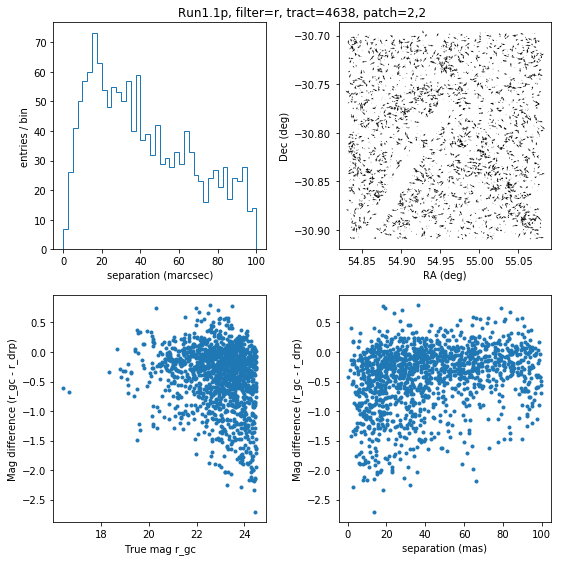

In [12]:
# Start a 2x2 panel figure:
fig = plt.figure(figsize=(8, 8))
frame_axes = fig.add_subplot(111, frameon=False)
frame_axes.set_title(title)
frame_axes.get_xaxis().set_ticks([])
frame_axes.get_yaxis().set_ticks([])

delta_mag = drp_mag - gc_mag  # Observed - True

# Upper Left: Histogram of match separations.
fig.add_subplot(2, 2, 1)
plt.hist(sep, range=(0, 100), histtype='step', bins=40)
plt.xlabel('separation (marcsec)')
plt.ylabel('entries / bin')

# Upper Right: Quiver plot of (DRP - galaxy_catalog) positions on the sky.
fig.add_subplot(2, 2, 2)
plt.quiver(np.degrees(drp_catalog['coord_ra']),
           np.degrees(drp_catalog['coord_dec']),
           u, v)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

# Lower left: Difference in magnitudes vs true magnitude (mag_gc).
fig.add_subplot(2, 2, 3)
plt.errorbar(gc_mag, delta_mag, fmt='.')
plt.xlabel('True mag {}_gc'.format(filter_))
plt.ylabel('Mag difference ({0}_gc - {0}_drp)'.format(filter_))

# Difference in magnitudes vs separation.
fig.add_subplot(2, 2, 4)
plt.errorbar(sep, delta_mag, fmt='.')
plt.xlabel('separation (mas)')
plt.ylabel('Mag difference ({0}_gc - {0}_drp)'.format(filter_))

plt.tight_layout()

### Going Further

The available columns in a `SourceCatalog` can be seen by printing the info from the schema that it carries around with it. The cells below show you what you have available. The drp_catalog and galaxy_catalog that we made to do the spatial matching only have positions and magnitudes in them - but the parent catalogs have many more quantities. 

In [13]:
for item in drp_catalog.schema:
    print("{}:  {}".format(item.field.getName(), item.field.getDoc()))

id:  unique ID
coord_ra:  position in ra/dec
coord_dec:  position in ra/dec
parent:  unique ID of parent source
mag_r:  r-magnitude


In [14]:
for item in galaxy_catalog.schema:
    print("{}:  {}".format(item.field.getName(), item.field.getDoc()))

id:  unique ID
coord_ra:  position in ra/dec
coord_dec:  position in ra/dec
parent:  unique ID of parent source
mag_r:  r-magnitude


In [15]:
# All the DRP measurements:
for item in catalog.schema:
    print("{}:  {}".format(item.field.getName(), item.field.getDoc()))

id:  unique ID
coord_ra:  position in ra/dec
coord_dec:  position in ra/dec
parent:  unique ID of parent source
merge_footprint_i:  Detection footprint overlapped with a detection from filter i
merge_footprint_r:  Detection footprint overlapped with a detection from filter r
merge_footprint_z:  Detection footprint overlapped with a detection from filter z
merge_footprint_g:  Detection footprint overlapped with a detection from filter g
merge_footprint_y:  Detection footprint overlapped with a detection from filter y
merge_footprint_u:  Detection footprint overlapped with a detection from filter u
merge_footprint_sky:  Detection footprint overlapped with a detection from filter sky
merge_peak_i:  Peak detected in filter i
merge_peak_r:  Peak detected in filter r
merge_peak_z:  Peak detected in filter z
merge_peak_g:  Peak detected in filter g
merge_peak_y:  Peak detected in filter y
merge_peak_u:  Peak detected in filter u
merge_peak_sky:  Peak detected in filter sky
deblend_nChild:  Nu

In [16]:
# All the protoDC2 parameters:
# help(gc)
gc.list_all_quantities()

['mag_y_lsst',
 'mag_r_sdss_no_host_extinction',
 'sed_2998_186_disk_no_host_extinction',
 'sed_2407_591_disk',
 'sed_1552_381_bulge_no_host_extinction',
 'sed_13177_1966_no_host_extinction',
 'sed_1000_246_no_host_extinction',
 'ellipticity_1_bulge_true',
 'Mag_true_z_sdss_z0',
 'sed_3184_197',
 'size_bulge_true',
 'Mag_true_g_sdss_z0',
 'sed_3812_236',
 'sed_5148_319_bulge_no_host_extinction',
 'sed_7843_486_bulge',
 'sed_17402_2596_disk',
 'ellipticity_2_bulge_true',
 'R_v',
 'sed_9978_1489_no_host_extinction',
 'sed_5806_360',
 'sed_4299_266',
 'sed_2407_591_disk_no_host_extinction',
 'mag_r_sdss',
 'sed_9395_583',
 'sed_4565_283_disk',
 'sed_17402_2596_bulge',
 'sed_8329_517_bulge',
 'mag_i_sdss_no_host_extinction',
 'mag_y',
 'sed_4299_266_no_host_extinction',
 'mag_true_u',
 'sed_3184_197_bulge_no_host_extinction',
 'sed_3381_209_bulge_no_host_extinction',
 'is_central',
 'sed_1933_474_bulge_no_host_extinction',
 'Mag_true_z_sdss_z0_no_host_extinction',
 'sed_8329_517',
 'Mag_tr